# Titanic Project with DNN

Predict survival on the Titanic using an artificial neural network in Keras

This project is based on a dataset containing demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. You can view a description of this dataset on the [Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and prepare the data

In [2]:
data_path = 'data/titanic_data.csv'
df = pd.read_csv(data_path)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
targets = ['Survived']

df = df[features + targets]

# # convert dataframe values to numerical
# df = df.apply(pd.to_numeric, errors='coerce')

# Reeplace NaN values with mean
df.fillna(df.mean(), inplace=True)

df.dtypes
# df.describe()

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Survived      int64
dtype: object

### Visualize data

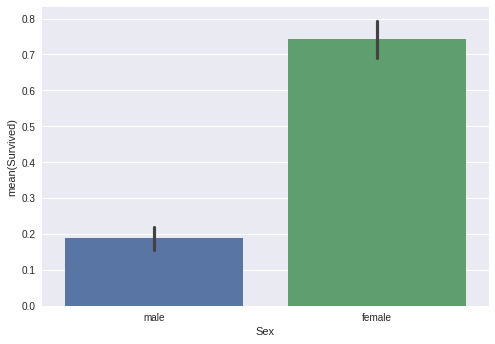

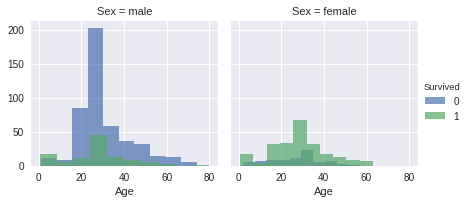

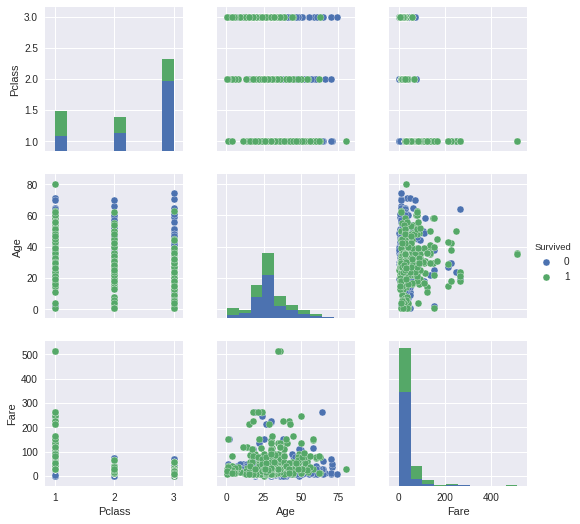

In [4]:
sns.barplot(x='Sex',y='Survived', data=df)
sns.FacetGrid(df, col="Sex",hue="Survived").map(plt.hist, "Age", alpha=.7).add_legend();
sns.pairplot(df, hue='Survived', vars=['Pclass', 'Age', 'Fare'])

### Dummy variables

In [5]:
dummy_fields = ['Sex']

# Process categorical variables 
dummy_fields = [d for d in dummy_fields if d in df]
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
df = df.drop(dummy_fields, axis='columns')

### Scaling target variables
The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for f in quant_features:
    mean, std = df[f].mean(), df[f].std()
    scaled_features[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std

df.head()

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_female,Sex_male
0,0.826913,-0.592148,0.432550,-0.473408,-0.502163,0,0,1
1,-1.565228,0.638430,0.432550,-0.473408,0.786404,1,1,0
2,0.826913,-0.284503,-0.474279,-0.473408,-0.488580,1,1,0
3,-1.565228,0.407697,0.432550,-0.473408,0.420494,1,1,0
4,0.826913,0.407697,-0.474279,-0.473408,-0.486064,0,0,1


### Tune features selection

In [7]:
fields_to_drop = []
data = df.drop(fields_to_drop, axis=1)
# filtered dataset now in 'data'
data.head()

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_female,Sex_male
0,0.826913,-0.592148,0.432550,-0.473408,-0.502163,0,0,1
1,-1.565228,0.638430,0.432550,-0.473408,0.786404,1,1,0
2,0.826913,-0.284503,-0.474279,-0.473408,-0.488580,1,1,0
3,-1.565228,0.407697,0.432550,-0.473408,0.420494,1,1,0
4,0.826913,0.407697,-0.474279,-0.473408,-0.486064,0,0,1


### Splitting the data into training, testing, and validation sets

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,  test_size=0.25, random_state=9)

# Separate the data into features and targets (x=features, y=targets)
x_train, y_train_nc = train.drop(targets, axis=1).values, train[targets].values
x_test, y_test_nc = test.drop(targets, axis=1).values, test[targets].values
# _nc: non-categorical yet

# no validation set; categorical_crossentropy will be used here

### One-hot encoding

In [9]:
np.random.seed(9)
import keras

# One-hot encoding the output 
num_classes = 2
y_train = keras.utils.to_categorical(y_train_nc, num_classes)
y_test = keras.utils.to_categorical(y_test_nc, num_classes)
print(x_train.shape ,y_train.shape)
print(x_test.shape,y_test.shape)

Using TensorFlow backend.


(668, 7) (668, 2)
(223, 7) (223, 2)


## Deep Neural Network
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 56)                448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 114       
Total params: 562.0
Trainable params: 562.0
Non-trainable params: 0.0
_________________________________________________________________
Training ....
Epoch 00183: early stopping
Training: loss: 0.385 ... Training Accuracy: 0.838
Validation: loss: 0.400 ... Validation Accuracy: 0.814


(0.7, 0.9)

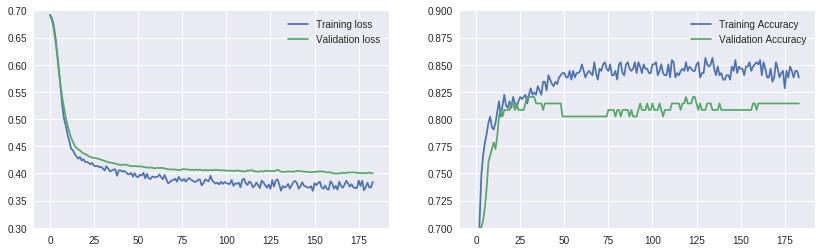

In [10]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
keras.optimizers.Adam
#from keras.layers.advanced_activations import LeakyReLU

nodes = x_train.shape[1]*8

weights = keras.initializers.RandomNormal(stddev=0.001)

model = Sequential()
model.add(Dense(nodes, input_dim=x_train.shape[1], activation='relu',
               kernel_initializer=weights,
               bias_initializer = 'zero'))
model.add(Dropout(.2))

model.add(Dense(2,activation='softmax',
               kernel_initializer = weights,
               bias_initializer = 'zero'))


# opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt = keras.optimizers.adam()

model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)]

print('Training ....')

history = model.fit(x_train, y_train, epochs=1000, batch_size=64, verbose=0, 
                    validation_split=0.25, callbacks=callbacks)

print("Training: loss: {:.3f} ... Training Accuracy: {:.3f}".format(
    history.history['loss'][-1], history.history['acc'][-1]))
print("Validation: loss: {:.3f} ... Validation Accuracy: {:.3f}".format(
    history.history['val_loss'][-1], history.history['val_acc'][-1]))

plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.ylim(ymin=0.3, ymax=0.7)
plt.subplot(122)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.ylim(ymin=0.7, ymax=0.9)

## Evaluating the model

In [11]:
score = model.evaluate(x_test, y_test, verbose=1)
print(" Test Accuracy: {:.4f}".format(score[1]))

 32/223 [===>..........................] - ETA: 0s Test Accuracy: 0.7937
